# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import json

Configuration

In [2]:
prop, level = 'ip', 'mopac_pm7-acn-adiabatic'

## Gather outputs from runs
Get the configuration and test summary

In [3]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 10 completed runs


In [4]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'params.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    return output

In [5]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('mean_absolute_error')
summary.head()

,path,starting_model,atom_features,message_steps,output_layers,reduce_op,atomwise,num_epochs,batch_size,lower_levels,property,level,name,data_hash,mean_absolute_error,r2_score,mean_squared_error
2,runs/f=128-T=4-r=sum-atomwise=False-hash=b638e13f,runs,128,4,"[64, 32, 32]",sum,False,32,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",ip,mopac_pm7-acn-adiabatic,oxidation_potential,7c0c3a2deb373b8186228139b6ec7b9b,0.149285,0.743468,0.050280
6,runs/f=64-T=4-r=sum-atomwise=False-hash=a7af1717,runs,64,4,"[64, 32, 32]",sum,False,512,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",ip,mopac_pm7-acn-adiabatic,oxidation_potential,7c0c3a2deb373b8186228139b6ec7b9b,0.150801,0.745228,0.049935
0,runs/f=128-T=4-r=sum-atomwise=True-hash=5e491898,runs,128,4,"[64, 32, 32]",sum,True,32,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",ip,mopac_pm7-acn-adiabatic,oxidation_potential,7c0c3a2deb373b8186228139b6ec7b9b,0.151144,0.744832,0.050013
4,runs/f=128-T=4-r=sum-atomwise=False-hash=b8baa9ad,runs,128,4,"[64, 32, 32]",sum,False,512,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",ip,mopac_pm7-acn-adiabatic,oxidation_potential,7c0c3a2deb373b8186228139b6ec7b9b,0.151150,0.736880,0.051572
8,runs/f=128-T=4-r=mean-atomwise=False-hash=e458...,runs,128,4,"[64, 32, 32]",mean,False,32,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",ip,mopac_pm7-acn-adiabatic,oxidation_potential,7c0c3a2deb373b8186228139b6ec7b9b,0.151466,0.741336,0.050698


## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [6]:
to_eval = summary.query(f'property=="{prop}" and level=="{level}"')

In [7]:
best = summary.sort_values('mean_squared_error').iloc[0]
best

path                    runs/f=64-T=4-r=sum-atomwise=False-hash=a7af1717
starting_model                                                      runs
atom_features                                                         64
message_steps                                                          4
output_layers                                               [64, 32, 32]
reduce_op                                                            sum
atomwise                                                           False
num_epochs                                                           512
batch_size                                                            32
lower_levels           [xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...
property                                                              ip
level                                            mopac_pm7-acn-adiabatic
name                                                 oxidation_potential
data_hash                               7c0c3a2deb3

In [8]:
log = pd.read_csv(best.path / 'log.csv')

Text(0, 0.5, 'Loss')

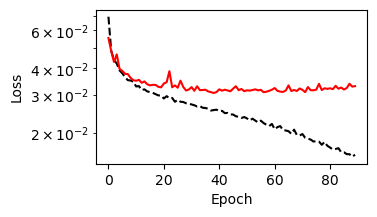

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogy(log.index, log['loss'], '--k')
ax.semilogy(log.index, log['val_loss'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

Early stopping is working!

## Plot the predicted vs actual
See if there are significant outliers, etc

In [10]:
test_data = pd.read_csv(best.path / 'test_results.csv')
print(f'Loaded {len(test_data)} test records')

Loaded 25911 test records


Text(0, 0.5, 'Actual')

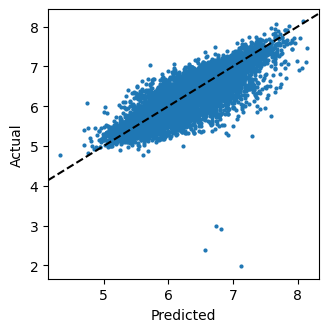

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['pred'], test_data['true'], s=4)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Save the top models
Get the path to the best model for each property, save a link to it

In [12]:
best_dir = Path("best_models")
if best_dir.is_dir():
    shutil.rmtree(best_dir)
best_dir

PosixPath('best_models')

In [13]:
for (prop, level), group in summary.groupby(['name', 'level']):
    (best_dir / prop).mkdir(exist_ok=True, parents=True)
    best = group.sort_values('mean_absolute_error', ascending=True).iloc[0]
    print(f'Best for {prop}/{level}: {best.path}')
    out_dir = best_dir / prop / level
    out_dir.symlink_to(best.path.absolute())

Best for oxidation_potential/mopac_pm7-acn-adiabatic: runs/f=128-T=4-r=sum-atomwise=False-hash=b638e13f
